# WebScraping

*Author: Subin Moon*

---

**What** - The Most Frequent Winning Numbers of Canada Lotto Max since 2009

---

**Why** - The goal of this project is to teach myself:

- basic big data principles
- ETL process
- Python 3
- Pandas

---

**How**

1. Scrape the result date, numbers, and prize since 2009 from the website
(https://www.lottonumbers.com/lotto-max-results-2009)

2. Load the data in a csv file

3. Find the most frequent numbers and rank them


---

## Install

In [1]:
#!pip install pandas
!pip install bs4
#!pip install requests

## Imports

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

## Extract Data Using a Webscraper

The LottoNumbers website (https://www.lottonumbers.com/lotto-max-results-2009) provides winning numbers since 2009, the first day of Lotto Max. 

### Scrape Webpage Contents

In [3]:
def make_url(url, years):
    urls = []
    for year in years:
        new_url = url + str(year)
        urls.append(new_url)
    return urls

In [4]:
# Request HTML pages
def request_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        
    except HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
        
    except Exception as err:
        print(f"Other error occurred: {err}")
        
    else: 
        print("Success!")
    finally:
        return response
    
# MAKE HTML DATA INTO A LIST!!!!!!!
html_data = request_url("https://www.lottonumbers.com/lotto-max-results-2009").text

Success!


### Extract Function

Scrape the data and convert to dataframe.

Data includes:
- Result dates
- Winning numbers
- Winning Prize

In [5]:
def extract(html_data):
    soup = BeautifulSoup(html_data, 'html5lib')

    # Find a lottery table
    tables = soup.find_all('table', class_='lotteryTable')

    # Convert to a dataframe
    df_list = pd.read_html(str(tables), flavor='bs4')
    df = pd.concat(df_list)

    return df

### Transform Functions

Transform the extracted data.

1. Reformat the Result Date with the format YYYY-MM-DD
2. Convert the numbers from string to lists of integers
3. Convert the winning prize to integer, and identify whether it's rollover

In [6]:
# Helper Functions
def get_bonus_num(row):
    # If the row of the given column is list or a tuple, get the last element
    if isinstance(row, (list, tuple)):
        return row.pop(-1)
    
    # Otherwise just return the value
    else:
        return row
    
def identify_rollover(row):
    if "R" in row:
        return row[5:-3]
    else:
        return row[5:]

In [7]:
def transform_date(data):
    # Parse strings into datetimes
    data["Result Date"] = pd.to_datetime(data["Result Date"])
    # Reformat dates
    time_format = "%Y-%h-%d %A"
    data["Result Date"] = data["Result Date"].dt.strftime(time_format)
    
def transform_numbers(data):
    # Convert from string to list of eight integers (including bonus)
    data["Numbers"] = data["Numbers"].apply(lambda x: x[0::].split("  "))
    
    # Create Bonus Number column
    data["Bonus Number"] = data["Numbers"].apply(get_bonus_num)

def transform_prize(data):
    data["Rollover"] = data["Jackpot"].str.contains("R")

    data["Prize"] = data["Jackpot"].apply(identify_rollover)
    
def transform(data):
    transform_date(data)
    transform_numbers(data)
    transform_prize(data)

Make a new dataframe with columns of "Date", "Numbers", "Prize", "Rollover"

- "Date": YY-MM-DD
- "Numbers": a list of integers
- "Prize": an integer
- "Rollover": a Boolean indicating whether the draw is rollover

In [8]:
columns = ["Result Date", "Numbers", "Bonus Number", "Prize", "Rollover"]

### Load Function

Load the data into a csv file called "lotto_max_winning_data.csv"

In [9]:
targetfile = "lottoMax_results.csv"

def load(targetfile, data):
    data_to_load = pd.DataFrame(data, columns=columns)
    data_to_load.to_csv(targetfile, index=False)

## Logging Function

A logging function to log the data:

In [10]:
def log(message):
    timestamp_format = "%Y-%h-%d-%H:%M:%S"
    now = datetime.now()
    timestamp = now.strftime(timestamp_format)
    with open("logfile.txt", "a") as open_file:
        open_file.write(timestamp + "," + message + "\n")

---

## ETL Process

In [11]:
log("ETL Job Started")

### Extract

In [12]:
log("Extract phase Started")

In [13]:
years = [x for x in range(2009, 2022)]
url = "https://www.lottonumbers.com/lotto-max-results-"

urls = make_url(url, years)
html_data = ""

for url in urls:
    html_data += request_url(url).text

Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!


In [14]:
data = extract(html_data)

data.head(5)

,Result Date,Numbers,Jackpot
0,Friday 25th December 2009,8 9 12 13 29 30 31 47,"CAD $25,000,000 R"
1,Friday 18th December 2009,8 10 15 17 33 34 35 13,"CAD $20,000,000 R"
2,Friday 11th December 2009,1 4 5 7 22 29 48 13,"CAD $15,000,000 R"
3,Friday 4th December 2009,1 6 13 19 32 35 40 7,"CAD $10,000,000 R"
4,Friday 27th November 2009,11 15 24 26 37 38 43 17,"CAD $25,000,000"


In [15]:
log("Extract phase Ended")

### Transform

In [16]:
log("Transform phase Started")

In [17]:
transform(data)

data.head(5)

,Result Date,Numbers,Jackpot,Bonus Number,Rollover,Prize
0,2009-Dec-25 Friday,"[8, 9, 12, 13, 29, 30, 31]","CAD $25,000,000 R",47,True,"25,000,000"
1,2009-Dec-18 Friday,"[8, 10, 15, 17, 33, 34, 35]","CAD $20,000,000 R",13,True,"20,000,000"
2,2009-Dec-11 Friday,"[1, 4, 5, 7, 22, 29, 48]","CAD $15,000,000 R",13,True,"15,000,000"
3,2009-Dec-04 Friday,"[1, 6, 13, 19, 32, 35, 40]","CAD $10,000,000 R",7,True,"10,000,000"
4,2009-Nov-27 Friday,"[11, 15, 24, 26, 37, 38, 43]","CAD $25,000,000",17,False,"25,000,000"


In [18]:
log("Transform phase Ended")

### Load

In [19]:
log("Load phase Started")

In [20]:
columns = ["Result Date", "Numbers", "Bonus Number", "Prize", "Rollover"]

In [21]:
targetfile = "lottoMax_results.csv"

load(targetfile, data)

In [22]:
log("Load phase Ended")

---

## Find the luckiest numbers

From the loaded data, rank the luckiest numbers

### Load the data

In [23]:
csv_path = "lottoMax_results.csv"

data = pd.read_csv(csv_path)

data.head(5)

,Result Date,Numbers,Bonus Number,Prize,Rollover
0,2009-Dec-25 Friday,"['8', '9', '12', '13', '29', '30', '31']",47,"25,000,000",True
1,2009-Dec-18 Friday,"['8', '10', '15', '17', '33', '34', '35']",13,"20,000,000",True
2,2009-Dec-11 Friday,"['1', '4', '5', '7', '22', '29', '48']",13,"15,000,000",True
3,2009-Dec-04 Friday,"['1', '6', '13', '19', '32', '35', '40']",7,"10,000,000",True
4,2009-Nov-27 Friday,"['11', '15', '24', '26', '37', '38', '43']",17,"25,000,000",False


### Identify a type of rows of "Numbers" column

In [24]:
for i, l in enumerate(data["Numbers"]):
    print("list",i,"is",type(l))

list 0 is <class 'str'>
list 1 is <class 'str'>
list 2 is <class 'str'>
list 3 is <class 'str'>
list 4 is <class 'str'>
list 5 is <class 'str'>
list 6 is <class 'str'>
list 7 is <class 'str'>
list 8 is <class 'str'>
list 9 is <class 'str'>
list 10 is <class 'str'>
list 11 is <class 'str'>
list 12 is <class 'str'>
list 13 is <class 'str'>
list 14 is <class 'str'>
list 15 is <class 'str'>
list 16 is <class 'str'>
list 17 is <class 'str'>
list 18 is <class 'str'>
list 19 is <class 'str'>
list 20 is <class 'str'>
list 21 is <class 'str'>
list 22 is <class 'str'>
list 23 is <class 'str'>
list 24 is <class 'str'>
list 25 is <class 'str'>
list 26 is <class 'str'>
list 27 is <class 'str'>
list 28 is <class 'str'>
list 29 is <class 'str'>
list 30 is <class 'str'>
list 31 is <class 'str'>
list 32 is <class 'str'>
list 33 is <class 'str'>
list 34 is <class 'str'>
list 35 is <class 'str'>
list 36 is <class 'str'>
list 37 is <class 'str'>
list 38 is <class 'str'>
list 39 is <class 'str'>
list 40 is

list 419 is <class 'str'>
list 420 is <class 'str'>
list 421 is <class 'str'>
list 422 is <class 'str'>
list 423 is <class 'str'>
list 424 is <class 'str'>
list 425 is <class 'str'>
list 426 is <class 'str'>
list 427 is <class 'str'>
list 428 is <class 'str'>
list 429 is <class 'str'>
list 430 is <class 'str'>
list 431 is <class 'str'>
list 432 is <class 'str'>
list 433 is <class 'str'>
list 434 is <class 'str'>
list 435 is <class 'str'>
list 436 is <class 'str'>
list 437 is <class 'str'>
list 438 is <class 'str'>
list 439 is <class 'str'>
list 440 is <class 'str'>
list 441 is <class 'str'>
list 442 is <class 'str'>
list 443 is <class 'str'>
list 444 is <class 'str'>
list 445 is <class 'str'>
list 446 is <class 'str'>
list 447 is <class 'str'>
list 448 is <class 'str'>
list 449 is <class 'str'>
list 450 is <class 'str'>
list 451 is <class 'str'>
list 452 is <class 'str'>
list 453 is <class 'str'>
list 454 is <class 'str'>
list 455 is <class 'str'>
list 456 is <class 'str'>
list 457 is 

In [25]:
# eval(): Evaluate a string describing operations on DataFrame columns
data["Numbers"] = data["Numbers"].apply(eval)

### Rank the winning numbers

- If for-loop is used

`num_dict = {}
for numbers in data["Numbers"]:
    for num in numbers:
        if num not in num_dict:
            num_dict[num] = 1
        else:
            num_dict[num] += 1`
        

In [26]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

In [27]:
def get_rankings(data, column_name):
    try:
        result = to_1D(data[column_name]).value_counts()
    except TypeError:
        result = data[column_name].value_counts()
    finally:    
        rank = pd.DataFrame(result).reset_index()
        rank.index += 1
        rank.rename(columns={"index":"Number",  0: "Frequency", "Bonus Number": "Frequency"}, inplace=True)
        return rank

rank = get_rankings(data, "Numbers")
rank.head(5)

,Number,Frequency
1,39,131
2,24,126
3,19,123
4,28,119
5,38,117


In [28]:
def make_chart(rank, label):
    fig, ax = plt.subplots(figsize = (14, 4))
    ax.bar(rank["Number"], rank["Frequency"])
    ax.set_ylabel("Frequency", size=12)
    ax.set_title(f"The Luckiest {label} of Lotto Max", size=14)

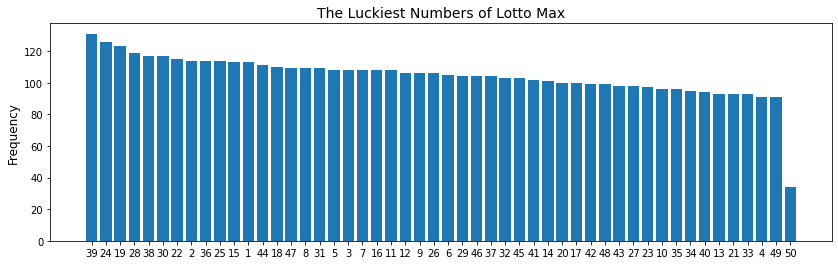

In [29]:
make_chart(rank, "Numbers")

### Rank the bonus numbers

In [30]:
bonus_rank = get_rankings(data, "Bonus Number")
bonus_rank.head(5)

,Number,Frequency
1,18,26
2,46,24
3,38,23
4,1,21
5,31,21


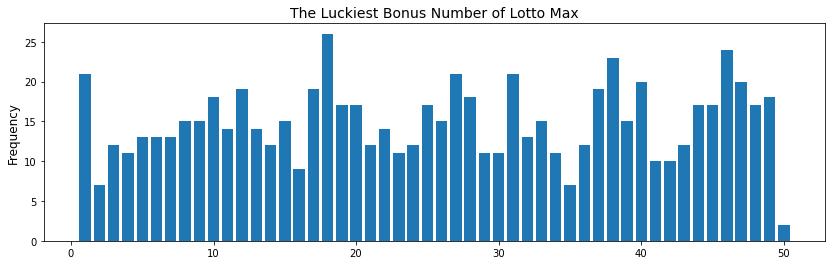

In [31]:
make_chart(bonus_rank, "Bonus Number")

---

## References

Function to_1D - https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173